## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

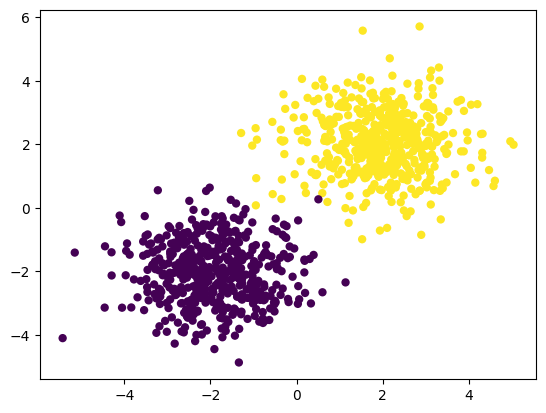

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [65]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(ReLU())
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 784 -> 128
ReLU
Linear 128 -> 10
ReLU
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 200

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

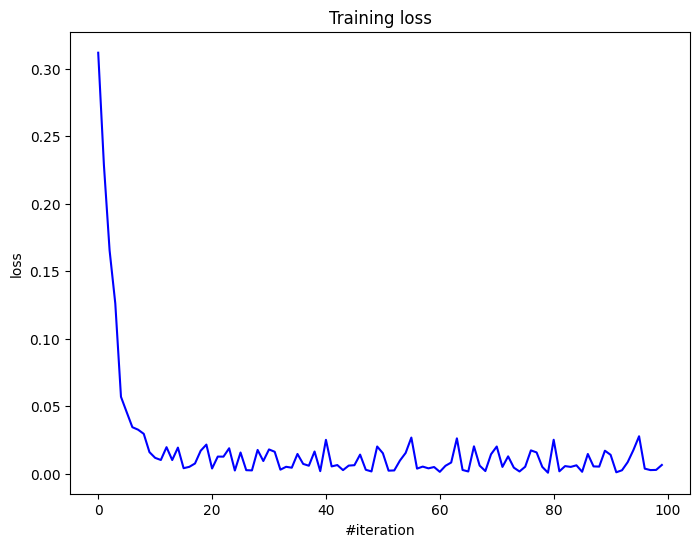

Current loss: 0.006452


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [157]:
# some sgdmomentum corrections

def sgd_momentum(variables, gradients, config, state):
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})

    var_index = 0
    for current_layer_vars, current_layer_grads in zip(variables, gradients):
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            #print(f'curr car shape:{current_var.shape}, curr grad shape: {current_grad.shape}')
            old_grad = np.zeros_like(current_grad)  # here was an error!
            state['accumulated_grads'].setdefault(var_index, old_grad)
            #print(f'old grad shape:{old_grad.shape}')
           # print('momentum ',config['momentum'], 'lr :', config['learning_rate'])
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)


            current_var -= old_grad
            var_index += 1

In [159]:
# load data
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [225]:
(X_train_old, y_train_old), (X_test_old, y_test_old) = mnist.load_data()
X_train_old, X_val_old, y_train_old, y_val_old = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [226]:
X_train_old, X_test_old = X_train_old / 255.0, X_test_old / 255.0

In [ ]:
# data preparation
X_train = X_train.reshape(X_train.shape[0], -1)
X_train, X_test = X_train / 255.0, X_test / 255.0

One-hot encode the labels first.

In [23]:
def ohe(data):
    unique_labels = np.unique(data)
    OHE = np.zeros((len(data), len(unique_labels)), dtype=int)

    for i, label in enumerate(unique_labels):
        OHE[:, i] = (data == label)

    return OHE

In [54]:
y_train = ohe(y_train)
y_val = ohe(y_val)
y_test = ohe(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [258]:
# handwritten GridSearch

import itertools
import copy

class gridSearchCV:
    def __init__(self, model, param_grid, optimizer=None, criterion=None, kfolds=5, n_epoch=20, batch_size=32):
        self.model = model
        self.criterion = criterion if criterion is not None else ClassNLLCriterion()
        self.optimizer = optimizer if optimizer is not None else sgd_momentum
        self.param_grid = param_grid
        self.kfolds = kfolds
        self.n_epoch = n_epoch
        self.batch_size = batch_size

        self.best_model = None
        self.best_params = None
        self.best_score = 0

    def fit(self, X, y):
        fold_size = len(X) // self.kfolds
        combinations = list(itertools.product(*self.param_grid.values()))

        # iterate over all possible param combinations
        for combination in combinations:
            curr_params = dict(zip(self.param_grid.keys(), combination))
            fold_scores = []

            # split dataset into K folds
            for i in range(self.kfolds):
                X_train = np.concatenate((X[:i*fold_size], X[(i+1)*fold_size:]))
                y_train = np.concatenate((y[:i*fold_size], y[(i+1)*fold_size:]))
                X_test = X[i*fold_size:(i+1)*fold_size]
                y_test = y[i*fold_size:(i+1)*fold_size]

                # train current model for n epochs
                for i in range(self.n_epoch):
                    # initialize model loss and optimizer state for current k-folds
                    optimizer_state = {}
                    curr_model = copy.deepcopy(self.model)
                    curr_criterion = copy.deepcopy(self.criterion)

                    # train model on current params
                    for x_batch, y_batch in get_batches((X_train, y_train), self.batch_size):
                        curr_model.zeroGradParameters()
                        # Forward
                        predictions = curr_model.forward(x_batch)
                        loss = curr_criterion.forward(predictions, y_batch)
                        # Backward
                        dp = curr_criterion.backward(predictions, y_batch)
                        curr_model.backward(x_batch, dp)
                        # Update weights
                        self.optimizer(curr_model.getParameters(),
                                    curr_model.getGradParameters(),
                                    curr_params,
                                    optimizer_state)

                # evaluate loss for current k-folds test set
                curr_model.training = False
                batch_scores = []
                for x_batch, y_batch in get_batches((X_test, y_test), self.batch_size):
                    # print('x batches:', x_batch[0], 'ys: ', y_batch)
                    predictions = curr_model.forward(x_batch)
                    loss = curr_criterion.forward(predictions, y_batch)
                    # append loss val to fold scores
                    batch_scores.append(loss)

                fold_scores.append(np.mean(batch_scores))

            # evaluate average loss over the k-folds and choose best params
            average_score = np.mean(fold_scores)
            if -average_score < self.best_score:
                self.best_model = curr_model
                self.best_params = curr_params
                self.best_score = -average_score

        return self.best_model

In [259]:
D = X_train.shape[1]

net1 = Sequential()
net1.add(Linear(D, 60))
net1.add(ReLU())
net1.add(Linear(60, 30))
net1.add(ReLU())
net1.add(Linear(30,10))
net1.add(ReLU())
net1.add(LogSoftMax())

net2 = Sequential()
net2.add(Linear(D, 60))
net2.add(ELU())
net2.add(Linear(60, 30))
net2.add(ELU())
net2.add(Linear(30,10))
net2.add(ELU())
net2.add(LogSoftMax())

net3 = Sequential()
net3.add(Linear(D, 60))
net3.add(SoftPlus())
net3.add(Linear(60, 30))
net3.add(SoftPlus())
net3.add(Linear(30,10))
net3.add(SoftPlus())
net3.add(LogSoftMax())


net4 = Sequential()
net4.add(Linear(D, 60))
net4.add(LeakyReLU())
net4.add(Linear(60, 30))
net4.add(LeakyReLU())
net4.add(Linear(30,10))
net4.add(LeakyReLU())
net4.add(LogSoftMax())

In [260]:
# choosing best hyperparams for each activation
param_grid  = {
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "momentum": [0.9, 0.95, 0.99, 0.999]
    }

for name, net in nets.items():
    gnet = gridSearchCV(net, param_grid, batch_size=64, n_epoch=2)
    gnet.fit(X_train[:3000], y_train[:3000])
    params = gnet.best_params

    print(f'{name}: {params}')

Relu: {'learning_rate': 0.0001, 'momentum': 0.99}
Elu: {'learning_rate': 0.0001, 'momentum': 0.999}
LeakyRelu: {'learning_rate': 0.0001, 'momentum': 0.9}
Softplus: {'learning_rate': 0.0001, 'momentum': 0.99}


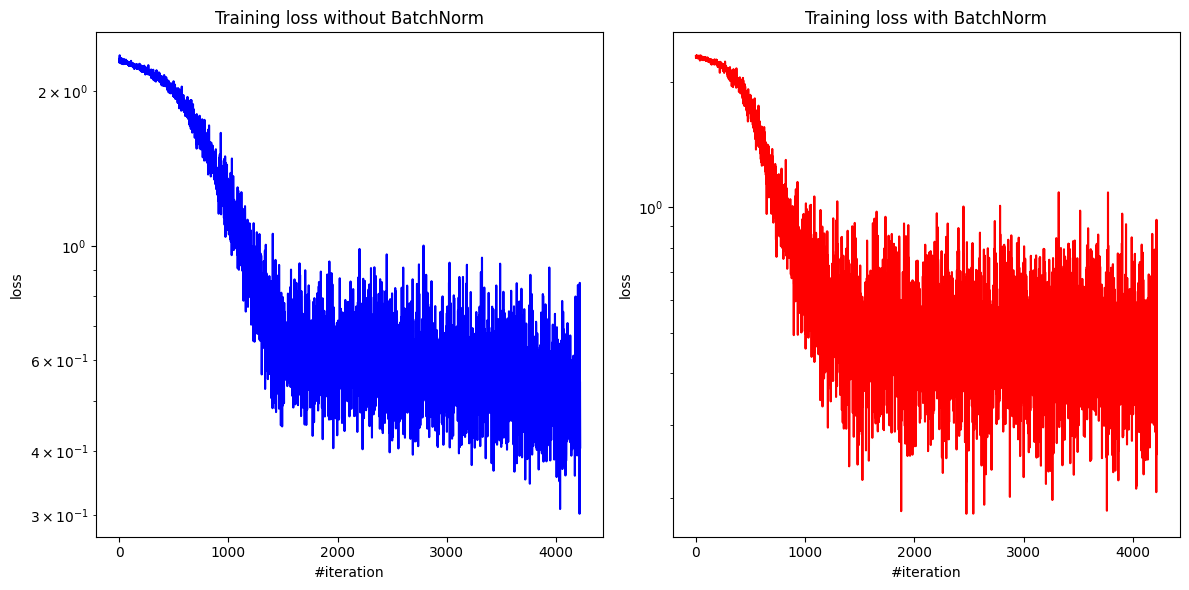

Current loss1: 0.406152
Current loss2: 0.255330
Current iteration: 2


In [245]:
# playing with BN

net01 = Sequential()
net01.add(Linear(784, 300))
net01.add(BatchNormalization())
net01.add(ChannelwiseScaling(300))
net01.add(ReLU())
net01.add(Linear(300, 80))
net01.add(BatchNormalization())
net01.add(ChannelwiseScaling(80))
net01.add(ReLU())
net01.add(Linear(80, 10))
net01.add(LogSoftMax())

net02 = Sequential()
net02.add(Linear(784, 300))
net02.add(ReLU())
net02.add(Linear(300, 80))
net02.add(ReLU())
net02.add(Linear(80, 10))
net02.add(LogSoftMax())

loss1_history = [] # without BN
loss2_history = [] # with BN

n_epoch = 3
batch_size = 32

optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.95}
optimizer_state = {}
criterion = ClassNLLCriterion()

for i in range(n_epoch):
    if i > 0:
        optimizer_config['learning_rate'] = 0.0005
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

        net01.zeroGradParameters()
        net02.zeroGradParameters()
        # Forward
        predictions1 = net01.forward(x_batch)
        predictions2 = net02.forward(x_batch)
        loss1 = criterion.forward(predictions1, y_batch)
        loss2 = criterion.forward(predictions2, y_batch)

        # Backward
        dp1 = criterion.backward(predictions1, y_batch)
        net01.backward(x_batch, dp1)

        dp2 = criterion.backward(predictions2, y_batch)
        net02.backward(x_batch, dp2)

        # Update weights
        sgd_momentum(net01.getParameters(),
                     net01.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        sgd_momentum(net02.getParameters(),
                     net02.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss1_history.append(loss1)
        loss2_history.append(loss2)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    # Plot loss without BatchNorm
    plt.subplot(1, 2, 1)
    plt.title("Training loss without BatchNorm")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss1_history, 'b')
    plt.yscale('log')  # Apply log scale for readability

    # Plot loss with BatchNorm
    plt.subplot(1, 2, 2)
    plt.title("Training loss with BatchNorm")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss2_history, 'r')
    plt.yscale('log')  # Apply log scale for readability

    plt.tight_layout()  # Adjust subplots to prevent overlap
    plt.show()

    print('Current loss1: %f' % loss1)
    print('Current loss2: %f' % loss2)
    print('Current iteration: %i' % i)



Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [220]:
# Your answer goes here. ################################################
print('It does help.')

It does help.


In [ ]:
# playing with BN

net11 = Sequential()
net11.add(Linear(784, 300))
net11.add(BatchNormalization())
net11.add(ChannelwiseScaling(300))
net11.add(ReLU())
net11.add(Linear(300, 80))
net11.add(BatchNormalization())
net11.add(ChannelwiseScaling(80))
net11.add(ReLU())
net11.add(Linear(80, 10))
net11.add(LogSoftMax())

net22 = Sequential()
net22.add(Linear(784, 300))
net22.add(ReLU())
net22.add(Linear(300, 80))
net22.add(ReLU())
net22.add(Linear(80, 10))
net22.add(LogSoftMax())

loss1_history = [] # without BN
loss2_history = [] # with BN

n_epoch = 3
batch_size = 32

optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.95}
optimizer_state = {}
criterion = ClassNLLCriterion()

for i in range(n_epoch):
    if i > 0:
        optimizer_config['learning_rate'] = 0.0005
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

        net01.zeroGradParameters()
        net02.zeroGradParameters()
        # Forward
        predictions1 = net01.forward(x_batch)
        predictions2 = net02.forward(x_batch)
        loss1 = criterion.forward(predictions1, y_batch)
        loss2 = criterion.forward(predictions2, y_batch)

        # Backward
        dp1 = criterion.backward(predictions1, y_batch)
        net01.backward(x_batch, dp1)

        dp2 = criterion.backward(predictions2, y_batch)
        net02.backward(x_batch, dp2)

        # Update weights
        sgd_momentum(net01.getParameters(),
                     net01.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        sgd_momentum(net02.getParameters(),
                     net02.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss1_history.append(loss1)
        loss2_history.append(loss2)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 6))

    # Plot loss without BatchNorm
    plt.subplot(1, 2, 1)
    plt.title("Training loss without BatchNorm")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss1_history, 'b')
    plt.yscale('log')  # Apply log scale for readability

    # Plot loss with BatchNorm
    plt.subplot(1, 2, 2)
    plt.title("Training loss with BatchNorm")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss2_history, 'r')
    plt.yscale('log')  # Apply log scale for readability

    plt.tight_layout()  # Adjust subplots to prevent overlap
    plt.show()

    print('Current loss1: %f' % loss1)
    print('Current loss2: %f' % loss2)
    print('Current iteration: %i' % i)


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [231]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # Randomly rotate the images by up to 10 degrees
    width_shift_range=0.1,  # Randomly shift the images horizontally by up to 10% of the width
    height_shift_range=0.1,  # Randomly shift the images vertically by up to 10% of the height
    zoom_range=0.1,  # Randomly zoom in on the images by up to 10%
    horizontal_flip=True  # Randomly flip the images horizontally
)

# Generate augmented data
X_train_aug = []
for image in X_train_old:
    augmented_images = datagen.flow(image[None,None,None,:], batch_size=1)
    X_train_aug.append(augmented_images[0][0])


In [241]:
nnet = Sequential()
nnet.add(Linear(784, 1000))
nnet.add(BatchNormalization())
nnet.add(ChannelwiseScaling(1000))
nnet.add(ReLU)
nnet.add(Linear(1000, 2000))
nnet.add(BatchNormalization())
nnet.add(ChannelwiseScaling(2000))
nnet.add(ReLU)
nnet.add(Dropout())
nnet.add(Linear(2000, 500))
nnet.add(ReLU)
nnet.add(BatchNormalization())
nnet.add(ChannelwiseScaling(500))
nnet.add(Linear(500,10))
nnet.add(ReLU())
nnet.add(SoftMax())

In [266]:

# training params
n_epochs = 30
batch_size = 32
lr = 0.001
loss_history = []

# optimizer params
config = {'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}
variables = [[np.arange(10).astype(np.float64)]]
gradients = [[np.arange(10).astype(np.float64)]]
state = {}

# find best hyperparams
param_grid = {
          'learning_rate': [1e-2, 1e-3, 1e-4],
          'beta1': [0.9, 0.99],
          'beta2':[0.999],
          'epsilon':[1e-8]}

gnet = gridSearchCV(nnet, param_grid, optimizer = adam_optimizer, batch_size=32, n_epoch=3)
gnet.fit(X_train[:3000], y_train[:3000])
params = gnet.best_params

print(f'{name}: {params}')


TypeError: Module.zeroGradParameters() missing 1 required positional argument: 'self'

In [251]:
print(gnet.best_score)

2.3060219618793205


In [ ]:

nnet.training = True
for i in range(n_epochs):
    for x_batch, y_batch in get_batches((X_train_aug, y_train), batch_size):

            net01.zeroGradParameters()
            net02.zeroGradParameters()
            # Forward
            predictions1 = net01.forward(x_batch)
            predictions2 = net02.forward(x_batch)
            loss1 = criterion.forward(predictions1, y_batch)
            loss2 = criterion.forward(predictions2, y_batch)

            # Backward
            dp1 = criterion.backward(predictions1, y_batch)
            net01.backward(x_batch, dp1)



adam_optimizer(variables, gradients, config, state)
# randomly augment data
# Your code goes here. ################################################

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.